<Axes: >

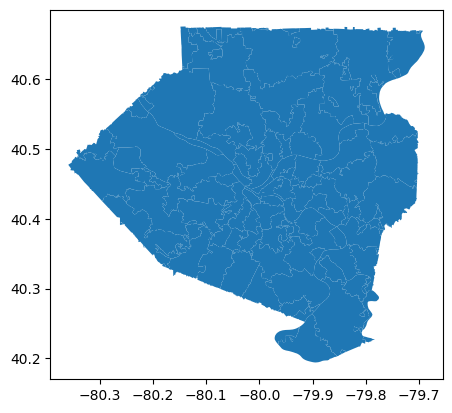

In [3]:
#!unzip Allegheny.zip
%matplotlib inline

# Unclutter the display.
import pandas as pd
import numpy as np
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import matplotlib.pyplot as plt

try:
  import geopandas as gpd
except:
  !pip install geopandas
  import geopandas as gpd

#Get the map
fp = "Allegheny/Allegheny_County_Zip_Code_Boundaries.shp"

#reading the file stored in variable fp
map_df = gpd.read_file(fp)
map_df = map_df.to_crs(epsg=4326)
map_df.plot()

In [4]:
#read INF model data
df = pd.read_csv("loc120f.txt",header=0,sep='\s+')
#read OUD model data
df2 = pd.read_csv("loc120.txt",header=0,sep='\s+')

In [5]:
def getList(df):
  arr = df.to_numpy()
  arr_loc = np.zeros((len(map_df)))
  print(len(arr))
  for i in range(len(arr)):
          point = Point(arr[i][1],arr[i][0])
          for j in range(len(map_df.index)):
              x=map_df['geometry'].loc[j]
              if x.contains(point) or x.touches(point):
                  arr_loc[j] = arr_loc[j]+1
  return arr_loc

arr_loc = getList(df)
merged = map_df.join(pd.DataFrame(arr_loc,columns=['n']))        

197


In [6]:
#Calling GPFLow library
try:
    import gpflow
except:
    !pip install gpflow tensorflow~=2.10.0 tensorflow-probability~=0.18.0
    import gpflow

# INF part

In [7]:
import tensorflow as tf

#getting centers for each ZIP area code
ls = np.zeros((len(map_df),2))
for i in range(len(map_df['geometry'])):
    ls[i,0]=map_df['geometry'].loc[i].centroid.x
    ls[i,1]=map_df['geometry'].loc[i].centroid.y

#Reformat the y list
y = [merged['n'].to_list()]
y=np.reshape(np.array(y), (-1,1))

#Calling the model
model = gpflow.models.GPR(
    (ls, y),
    kernel=gpflow.kernels.SquaredExponential())

opt = gpflow.optimizers.Scipy()
#opt = tf.keras.optimizers.Adam()
opt.minimize(model.training_loss, model.trainable_variables)
y_pred,_=model.predict_y(ls)

Inferring result given data [^]
\begin{align}
               \theta        & \sim p(\theta) \\
               f             & \sim \mathcal{GP}(m(x), k(x, x'; \theta)) \\
               f_i           & = f(x_i) \\
               y_i \,|\, f_i & \sim p(y_i|f_i) \\ 
           \end{align}
where $m(x)$ is the mean fucntion and $k(.,.)$ is the kernel.   
*^  GPflow library ([library link](https://gpflow.github.io/))*

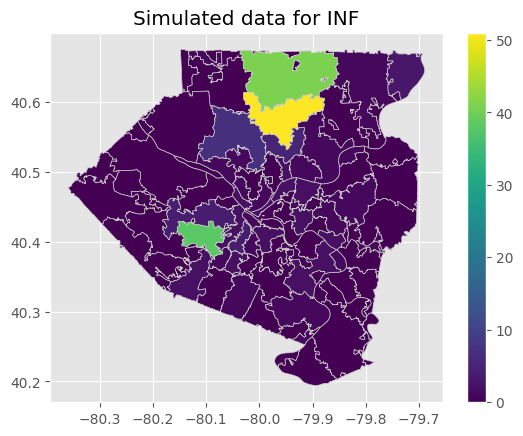

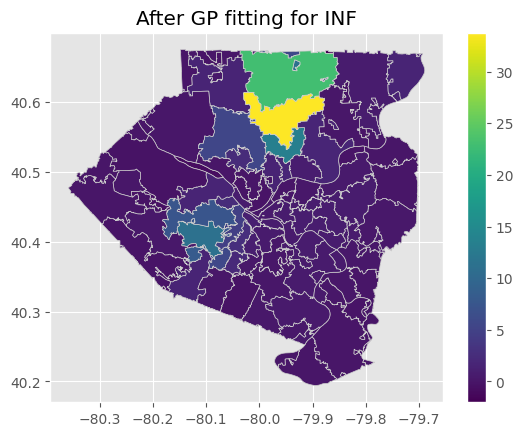

In [8]:
plt.style.use('ggplot')
fitting = map_df.join(pd.DataFrame(y_pred,columns=['n']))
#reality
plt.figure()
ax = plt.subplot(1,1,1)
ax.set_title("Simulated data for INF")
merged.plot(ax=ax,column='n', edgecolor='0.8',legend=True)
#fitted with GP
plt.figure()
ax = plt.subplot(1,1,1)
ax.set_title("After GP fitting for INF")
fitting.plot(ax=ax,column='n', edgecolor='0.8',legend=True)
plt.show()

In [9]:
#get the full covariance matrix
cov=model.predict_f(ls, full_cov=True)[1]
#making the covariance of unit 1 at diagonal
new_cov = [cov[0][i]/cov[0][i][i] for i in range(len(ls))]
#convert covariance to numpy array
new_cov=np.array(new_cov)

Inferring sample of kernel function given data [^]

\begin{align}
               \theta        & \sim p(\theta) \\
               f             & \sim \mathcal{GP}(m(x), k(x, x'; \theta)) \\
               f_i           & = f(x_i) \\
           \end{align}
^  GPflow library ([library link](https://gpflow.github.io/))

Text(0.5, 0.92, 'INF kernel (RBF)')

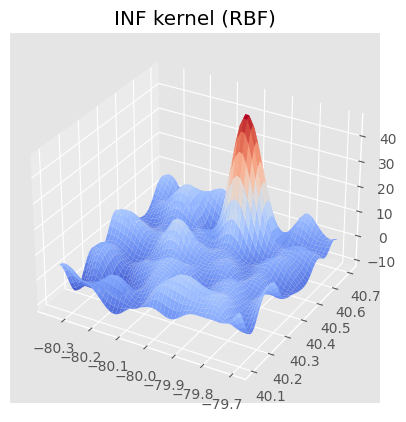

In [11]:
import tensorflow as tf
from matplotlib.axes import Axes
from matplotlib.cm import coolwarm

n_grid=50
Xplots = np.linspace(-80.35, -79.7, n_grid)
yplots = np.linspace(40.1, 40.7, n_grid)
Xplot1, Xplot2 = np.meshgrid(Xplots, yplots)
Xplot = np.stack([Xplot1, Xplot2], axis=-1)
Xplot = Xplot.reshape([n_grid ** 2, 2])

tf.random.set_seed(20220903)
fs = model.predict_f_samples(Xplot, num_samples=1)
fs = fs.numpy().reshape((n_grid, n_grid))
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(Xplot1, Xplot2, fs, cmap=coolwarm)
ax.set_title("INF kernel (RBF)")

In [22]:
#!pip install libpysal
#!pip install esda
from libpysal.weights import lat2W
from esda.moran import Moran
import numpy as np

# Use your matrix here, instead of this random one
Z = np.random.rand(200,150)

# Create the matrix of weigthts 
w = lat2W(new_cov.shape[0], new_cov.shape[1])

# Create the pysal Moran object 
mi = Moran(new_cov, w)

# Verify Moran's I results 
print(mi.I) 
print(mi.p_norm)

0.06813439490833323
0.0


# OUD part

In [ ]:
###############################################################
#Doing fitting for OUD model
arr_loc = getList(df2)
merged = map_df.join(pd.DataFrame(arr_loc,columns=['n']))

#Reformat the y list
y = [merged['n'].to_list()]
y=np.reshape(np.array(y), (-1,1))

#Calling the model
model = gpflow.models.GPR(
    (ls, y),
    kernel=gpflow.kernels.Matern12())

opt = gpflow.optimizers.Scipy()
#opt = tf.keras.optimizers.Adam()
opt.minimize(model.training_loss, model.trainable_variables)
y_pred,_=model.predict_y(ls)

Inferring result given data [^]
\begin{align}
               \theta        & \sim p(\theta) \\
               f             & \sim \mathcal{GP}(m(x), k(x, x'; \theta)) \\
               f_i           & = f(x_i) \\
               y_i \,|\, f_i & \sim p(y_i|f_i) \\ 
           \end{align}
where $m(x)$ is the mean fucntion and $k(.,.)$ is the kernel.   
*^  GPflow library ([library link](https://gpflow.github.io/))*

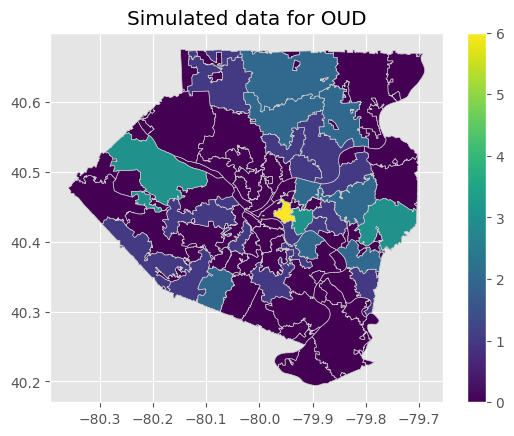

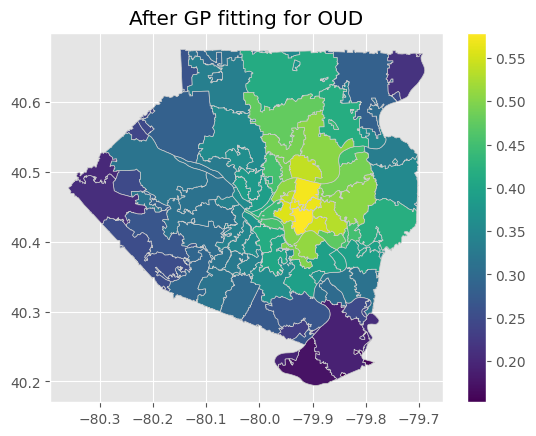

In [13]:
plt.style.use('ggplot')
fitting = map_df.join(pd.DataFrame(y_pred,columns=['n']))
#reality
plt.figure()
ax = plt.subplot(1,1,1)
ax.set_title("Simulated data for OUD")
merged.plot(ax=ax,column='n', edgecolor='0.8',legend=True)
#fitted with GP
plt.figure()
ax = plt.subplot(1,1,1)
ax.set_title("After GP fitting for OUD")
fitting.plot(ax=ax,column='n', edgecolor='0.8',legend=True)
plt.show()

In [14]:
#get the full covariance matrix
cov=model.predict_f(ls, full_cov=True)[1]
#making the covariance of unit 1 at diagonal
oud_cov = [cov[0][i]/cov[0][i][i] for i in range(len(ls))]
#convert covariance to numpy array
oud_cov=np.array(oud_cov)

Inferring sample of kernel function given data [^]

\begin{align}
               \theta        & \sim p(\theta) \\
               f             & \sim \mathcal{GP}(m(x), k(x, x'; \theta)) \\
               f_i           & = f(x_i) \\
           \end{align}
^  GPflow library ([library link](https://gpflow.github.io/))

Text(0.5, 0.92, 'OUD kernel (Matern)')

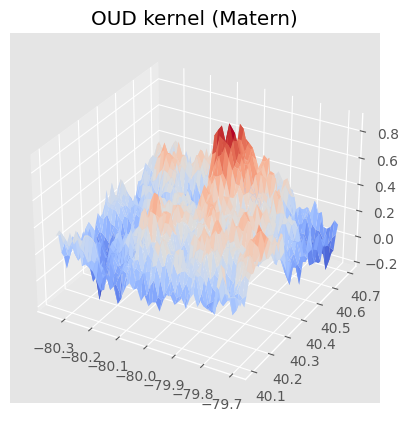

In [15]:
import tensorflow as tf
from matplotlib.axes import Axes
from matplotlib.cm import coolwarm

n_grid=50
Xplots = np.linspace(-80.35, -79.7, n_grid)
yplots = np.linspace(40.1, 40.7, n_grid)
Xplot1, Xplot2 = np.meshgrid(Xplots, yplots)
Xplot = np.stack([Xplot1, Xplot2], axis=-1)
Xplot = Xplot.reshape([n_grid ** 2, 2])

tf.random.set_seed(20220903)
fs = model.predict_f_samples(Xplot, num_samples=1)
fs = fs.numpy().reshape((n_grid, n_grid))
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(Xplot1, Xplot2, fs, cmap=coolwarm)
ax.set_title("OUD kernel (Matern)")

In [ ]:
from scipy.special import rel_entr
#KL-divergence test
print(sum(sum(rel_entr(oud_cov, new_cov))))

#second method
d = 1-(np.matrix.trace(oud_cov*new_cov)/ (np.linalg.norm(oud_cov)*np.linalg.norm(new_cov)))
print(d)

inf
0.7927476883678947


# Comparing two models with the same kernel

In [ ]:
#Doing fitting for INF model
arr_loc = getList(df)
merged = map_df.join(pd.DataFrame(arr_loc,columns=['n']))
#Reformat the y list
y = [merged['n'].to_list()]
y=np.reshape(np.array(y), (-1,1))

#Calling the model
model = gpflow.models.GPR(
    (ls, y),
    kernel=gpflow.kernels.SquaredExponential())

opt = gpflow.optimizers.Scipy()
#opt = tf.keras.optimizers.Adam()
opt.minimize(model.training_loss, model.trainable_variables)
y_pred,_=model.predict_y(ls)

###############################################################
#Doing fitting for OUD model
arr_loc = getList(df2)
merged = map_df.join(pd.DataFrame(arr_loc,columns=['n']))

#Reformat the y list
y = [merged['n'].to_list()]
y=np.reshape(np.array(y), (-1,1))

#Calling the model
model2 = gpflow.models.GPR(
    (ls, y),
    kernel=gpflow.kernels.SquaredExponential())

opt = gpflow.optimizers.Scipy()
#opt = tf.keras.optimizers.Adam()
opt.minimize(model2.training_loss, model2.trainable_variables)
y_pred,_=model2.predict_y(ls)

In [ ]:
#get the full covariance matrix
cov=model.predict_f(ls, full_cov=True)[1]
#making the covariance of unit 1 at diagonal
inf_cov = [cov[0][i]/cov[0][i][i] for i in range(len(ls))]
#convert covariance to numpy array
inf_cov=np.array(inf_cov)
####################################################################
#Doing same for OUD model
#get the full covariance matrix
cov=model2.predict_f(ls, full_cov=True)[1]
#making the covariance of unit 1 at diagonal
oud_cov = [cov[0][i]/cov[0][i][i] for i in range(len(ls))]
#convert covariance to numpy array
oud_cov=np.array(oud_cov)

In [ ]:
#Showing difference between two covaraince matrices
from scipy.special import rel_entr
#KL-divergence test
print(sum(sum(rel_entr(inf_cov, oud_cov))))

#second method
d = 1-(np.matrix.trace(oud_cov*inf_cov)/ (np.linalg.norm(oud_cov)*np.linalg.norm(inf_cov)))
print(d)

inf
0.9453234050151131
